In [644]:
from environment_data import EnvironmentData
from empty_structures import EmptyStructures
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import random
import networkx as nx

import sys
import os


class WorldData:
    environments: EnvironmentData = []

    def __init__(self):
        pass


class Climate:
    def __init__(self):
        self.type = ''
        self.season = ''
        self.weather = ''


class Environment:
    def __init__(self, env_type, season=None, climate=None):
        self.type = env_type
        self.zones = []
        self.climate = climate
        self.season = season
        self.level = 0
        self.description = ''
        self.name = ''
        self.climate = Climate()
        self.graph = nx.Graph()

    def add_zone(self, zone):
        self.zones.append(zone)

    def __str__(self):
        return f"{self.name} (depth {self.depth})"

    @staticmethod
    def generate_random_environment():
        environment_type = random.choice(WorldData.environments)
        season = random.choice(environment_type.seasons)
        climate = random.choice(environment_type.climates)
        environment = Environment(season=season, climate=climate, env_type=environment_type)
        return environment


class GameWorld:
    def __init__(self):
        self.environments = []

    def add_environment(self, environment):
        self.environments.append(environment)

    @staticmethod
    def generate_random_world():
        world = GameWorld()
        for i in range(3):
            environment = Environment.generate_random_environment()
            world.add_environment(environment)
        return world


class Zone:
    def __init__(self, name, depth):
        self.name = name
        self.depth = depth
        self.locations = []

    def add_location(self, location):
        self.locations.append(location)

    def __str__(self):
        return f"{self.name} (depth {self.depth})"


class Location:
    def __init__(self, name, depth, zone):
        self.name = name
        self.depth = depth
        self.zone = zone
        self.connections = []

    def add_connection(self, location):
        self.connections.append(location)

    def __str__(self):
        return f"{self.name} (depth {self.depth}) in {self.zone.name}"


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from die_generator import DieGenerator
from environment_generator import EnvironmentGenerator


# to generate a map, we first generate some random zones, and then generate locations within each zone that are relevant to the zone.

# each zone is given a random depth, and each location within a zone is assigned a random depth

# then we connect each location within a zone to other locations within the same zone, but a location may only be connected either to another location at the same depth, or another location that is at a depth that is plus or minus one.

# We then connect each in the same way, so that zones that share the same depth can be connected, or zones that have a depth that differs only by plus or minus one can be connected.

# And by doing this we end up with a map that can be navigated by the players, but makes somewhat logical sense in how it is connected.
def generate_map(n_zones=3, max_depth=3):
    zone_names = ['woodland', 'old ruins', 'bog', 'marsh', 'watchtower', 'abandoned keep', 'village', 'forest',
                  "outpost", "cave", "river", "mountain", "lake", "waterfall", "beach", "coast", "cliff", "canyon",
                  "desert", "oasis", "dunes", "jungle", "swamp", "volcano", "island", "grassland", "shrubland",
                  "wetland""estuary"]
    g = nx.Graph()

    min_locations = 3
    max_locations = 6
    # Create the zones and locations with associated depth
    zone_depths = [random.randint(1, max_depth) for _ in range(n_zones)]
    zones = [f"{zone_names[i]}" for i in range(n_zones)]
    for graph_zone, depth in zip(zones, zone_depths):
        n_locations = random.randint(min_locations, max_locations)
        loc_depths = [random.randint(1, max_depth) for _ in range(n_locations)]
        for j in range(n_locations):
            loc = f"{graph_zone}_{j}"
            g.add_edge(graph_zone, loc, depth=loc_depths[j])

        # Connect each location to at least one other location in the same zone
        for i in range(n_locations):
            loc1 = f"{graph_zone}_{i}"
            if g.degree(loc1) == 1:  # Connect to another location only if it has no other connections
                other_locs = [f"{graph_zone}_{j}" for j in range(n_locations) if j != i]
                loc2 = random.choice(other_locs)
                g.add_edge(loc1, loc2, depth=min(loc_depths[i], loc_depths[other_locs.index(loc2)]))

        # Connect locations within a zone respecting the depth rule
        for i in range(n_locations - 1):
            for j in range(i + 2, n_locations):
                if abs(loc_depths[i] - loc_depths[j]) <= 1:
                    loc1 = f"{graph_zone}_{i}"
                    loc2 = f"{graph_zone}_{j}"
                    g.add_edge(loc1, loc2, depth=min(loc_depths[i], loc_depths[j]))

    # Connect zones through locations respecting the depth rule
    for i in range(n_zones - 1):
        for j in range(i + 1, n_zones):
            if abs(zone_depths[i] - zone_depths[j]) <= 1:
                # Pick one random location from each zone
                n_loc_i = len([n for n in g.neighbors(zones[i])])
                n_loc_j = len([n for n in g.neighbors(zones[j])])

                loc1 = f"{zones[i]}_{random.randint(0, n_loc_i - 1)}"
                loc2 = f"{zones[j]}_{random.randint(0, n_loc_j - 1)}"
                g.add_edge(loc1, loc2, depth=min(zone_depths[i], zone_depths[j]))

    return g, zones, zone_depths


def generate_map3(n_zones=3, max_depth=3):
    zone_names = ['woodland', 'old ruins', 'bog', 'marsh', 'watchtower', 'abandoned keep', 'village', 'forest',
                  "outpost", "cave", "river", "mountain", "lake", "waterfall", "beach", "coast", "cliff", "canyon",
                  "desert", "oasis", "dunes", "jungle", "swamp", "volcano", "island", "grassland", "shrubland",
                  "wetland""estuary"]
    g = nx.Graph()

    min_locations = 3
    max_locations = 6

    # Randomly select n_zones from zone_names
    zones = random.sample(zone_names, n_zones)

    for zone in zones:
        zone_depth = random.randint(1, max_depth)
        g.add_node(zone, type="zone", depth=zone_depth)

        # Generate locations for this zone
        n_locations = random.randint(min_locations, max_locations)
        for j in range(n_locations):
            loc_depth = random.randint(1, max_depth)
            loc = f"{zone}_{j}"
            g.add_node(loc, type="location", depth=loc_depth, zone=zone)
            g.add_edge(zone, loc)

        # Interconnect locations in the same zone
        locations = [n for n in g.nodes if g.nodes[n]['type'] == 'location' and g.nodes[n]['zone'] == zone]
        for i in range(len(locations)):
            # Find the locations that satisfy the depth rule
            locs_in_depth_range = [n for n in locations if n != locations[i] and abs(g.nodes[n]['depth'] - g.nodes[locations[i]]['depth']) <= 1]

            # Select a random number (between 1 and the number of locations in depth range) of locations to connect
            if locs_in_depth_range:
                num_locs_to_connect = random.randint(1, max(1, len(locs_in_depth_range) // 2))
                locs_to_connect = random.sample(locs_in_depth_range, num_locs_to_connect)
                for loc in locs_to_connect:
                    g.add_edge(locations[i], loc)

    # Create connections between locations in different zones
    for i in range(n_zones - 1):
        for j in range(i + 1, n_zones):
            if abs(g.nodes[zones[i]]['depth'] - g.nodes[zones[j]]['depth']) <= 1:
                # Get locations in each zone
                locs_zone_i = [n for n in g.neighbors(zones[i])]
                locs_zone_j = [n for n in g.neighbors(zones[j])]

                # Get locations in the appropriate depth range
                locs_zone_i_in_range = [n for n in locs_zone_i if abs(g.nodes[n]['depth'] - g.nodes[zones[i]]['depth']) <= 1]
                locs_zone_j_in_range = [n for n in locs_zone_j if abs(g.nodes[n]['depth'] - g.nodes[zones[j]]['depth']) <= 1]

                # Make the connections only if there are locations in range in both zones
                if locs_zone_i_in_range and locs_zone_j_in_range:
                    # Determine the number of connections to make
                    n_connections = random.randint(1, min(len(locs_zone_i_in_range), len(locs_zone_j_in_range)))

                    # Make the connections
                    for _ in range(n_connections):
                        loc1 = random.choice(locs_zone_i_in_range)
                        loc2 = random.choice(locs_zone_j_in_range)

                        g.add_edge(loc1, loc2)

    return g


def connect_nodes_within_zones(g):
    zones = [n for n in g.nodes if g.nodes[n]['type'] == 'zone']

    for zone in zones:
        # Get locations in the zone
        locs_zone = [n for n in g.neighbors(zone)]

        # Find the disconnected components within the zone
        subgraph = g.subgraph(locs_zone)
        components = list(nx.connected_components(subgraph))

        # If there is more than one component, create connections to make the graph connected
        while len(components) > 1:
            # Randomly select two components and a node from each to create a connection
            comp1, comp2 = random.sample(components, 2)
            node1 = random.choice(list(comp1))
            node2 = random.choice(list(comp2))
            g.add_edge(node1, node2)

            # Recompute the connected components
            components = list(nx.connected_components(g.subgraph(locs_zone)))
    return g


def connect_all_zones(g):
    zones = [n for n in g.nodes if g.nodes[n]['type'] == 'zone']

    # Now we need to make sure that all zones are connected.
    # For this we can use the connected_components function again, but this time on the whole graph.
    components = list(nx.connected_components(g))

    while len(components) > 1:
        comp1, comp2 = random.sample(components, 2)
        node1 = random.choice(list(comp1))
        node2 = random.choice(list(comp2))
        g.add_edge(node1, node2)

        components = list(nx.connected_components(g))

    return g


def select_zones(zones):
    n_zones = random.randint(len(zones) // 2, len(zones))
    return random.sample(zones, n_zones)


def select_zone_depths(n_zones, max_depth):
    return [random.randint(1, max_depth) for _ in range(n_zones)]


def add_zone_locations_to_graph(g, zone, depth, max_depth):
    zone_name = zone["zone"]
    locations = zone["locations"]
    n_locations = random.randint(zone["locations_to_use"]["minimum"], zone["locations_to_use"]["maximum"])

    loc_depths = [random.randint(1, max_depth) for _ in range(n_locations)]
    for j in range(n_locations):
        loc = f"{zone_name}_{locations[j]['descriptor']}"
        g.add_edge(zone_name, loc, depth=loc_depths[j])
    return g


def connect_locations_within_zone(g, zone_name, locations, n_locations):
    loc_depths = get_depths_of_locations_in_zone(g, zone_name)
    # Connect each location to at least one other location in the same zone
    for i in range(n_locations):
        loc1 = f"{zone_name}_{locations[i]['descriptor']}"
        if g.degree(loc1) == 1:  # Connect to another location only if it has no other connections
            other_locs = [f"{zone_name}_{locations[j]['descriptor']}" for j in range(n_locations) if j != i]
            loc2 = random.choice(other_locs)
            g.add_edge(loc1, loc2, depth=min(loc_depths[i], loc_depths[other_locs.index(loc2)]))

    # Connect locations within a zone respecting the depth rule
    for i in range(n_locations - 1):
        for j in range(i + 2, n_locations):
            if abs(loc_depths[i] - loc_depths[j]) <= 1:
                loc1 = f"{zone_name}_{locations[i]['descriptor']}"
                loc2 = f"{zone_name}_{locations[j]['descriptor']}"
                g.add_edge(loc1, loc2, depth=min(loc_depths[i], loc_depths[j]))
    return g


def connect_zones(g, selected_zones, number_of_zones, zone_depths):
    # Connect zones through locations respecting the depth rule
    for i in range(number_of_zones - 1):
        for j in range(i + 1, number_of_zones):
            if abs(zone_depths[i] - zone_depths[j]) <= 1:
                # Pick one random location from each zone
                n_loc_i = len([n for n in g.neighbors(selected_zones[i]["zone"])])
                n_loc_j = len([n for n in g.neighbors(selected_zones[j]["zone"])])

                loc1 = f"{selected_zones[i]['zone']}_{selected_zones[i]['locations'][random.randint(0, n_loc_i - 1)]['descriptor']}"
                loc2 = f"{selected_zones[j]['zone']}_{selected_zones[j]['locations'][random.randint(0, n_loc_j - 1)]['descriptor']}"
                g.add_edge(loc1, loc2, depth=min(zone_depths[i], zone_depths[j]))
    return g


def get_depths_of_locations_in_zone(g, zone_name):
    depths = []
    for node1, node2, data in g.edges(data=True):
        if node1 == zone_name or node2 == zone_name:
            depths.append(data['depth'])
    return depths


def generate_map2(zones):
    g = nx.Graph()

    max_depth = len(zones)
    selected_zones = select_zones(zones)

    zone_depths = select_zone_depths(len(selected_zones), max_depth)

    for zone, depth in zip(selected_zones, zone_depths):
        g = add_zone_locations_to_graph(g, zone, depth, max_depth)
        g = connect_locations_within_zone(g, zone["zone"], zone["locations"], len(zone["locations"]))

    g = connect_zones(g, selected_zones, len(selected_zones), zone_depths)

    return g, [zone['zone'] for zone in selected_zones], zone_depths


# remove the zones, we no longer need to know about them, we're just interested in the locations
def remove_zones(g):
    zones = [n for n in g.nodes if g.nodes[n]['type'] == 'zone']
    for zone in zones:
        g.remove_node(zone)

    return g


def find_unreachable_node(g):
    nodes = list(g.nodes())

    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            if not nx.has_path(g, nodes[i], nodes[j]):
                return nodes[i]

# def connect_islands(g):
#     node = find_unreachable_node(g)
#     print(f"Unreachable node: {node}")
#
#     while len(groups) > 1:  # More than one group means there are unreachable nodes
#         # Select two different groups
#         group1, group2 = random.sample(groups, 2)
#
#         # If a group has only one node, connect this node with a node from a different group
#         if len(group1) == 1 and len(group2) > 1:
#             node1 = list(group1)[0]
#             node2 = random.choice([node for node in group2 if node != node1])
#         elif len(group2) == 1 and len(group1) > 1:
#             node1 = random.choice([node for node in group1 if node != list(group2)[0]])
#             node2 = list(group2)[0]
#         else:
#             node1, node2 = random.sample(list(group1) + list(group2), 2)
#
#         g.add_edge(node1, node2)
#
#         # Recalculate groups of unreachable nodes
#         node = find_unreachable_node(g)
#         print(f"Unreachable node: {node}")
#
#     return g


# a map is represented as a graph, at the top is the environment, and an environment encompasses a number of distinct zones, and within each zone there is a related set of locations.

#the_graph, the_zones, the_depths = generate_map2(EnvironmentGenerator.environments[0]['zones'])


# Printing the adjacency list of each node
# for line in nx.generate_adjlist(the_graph):
#     print(line)
#
# # Print the depth of each zone
# for zone, depth in zip(the_zones, the_depths):
#     print(f"{zone} depth: {depth}")


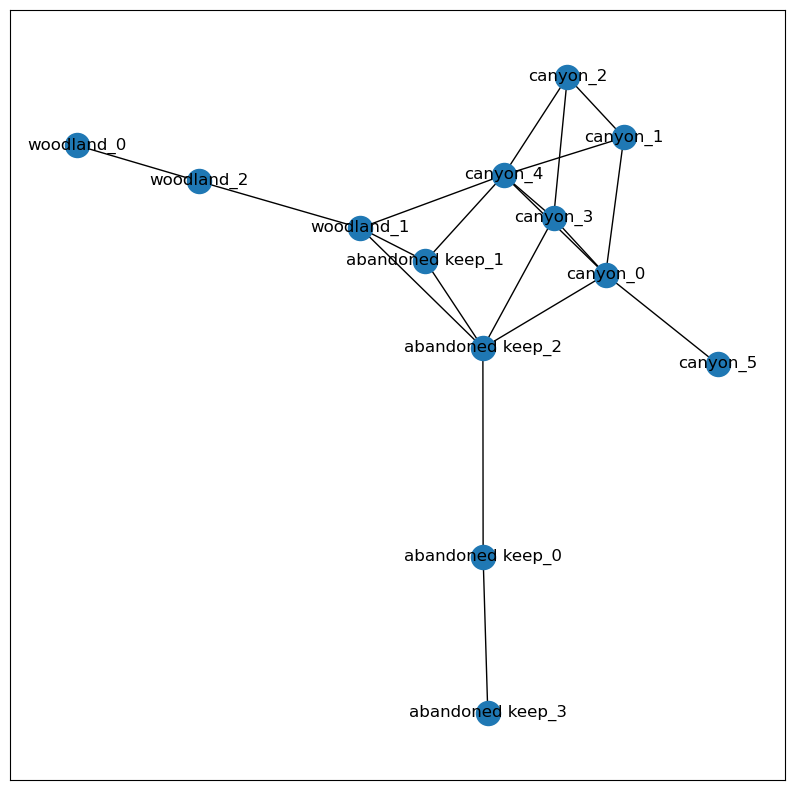

In [687]:
the_graph = generate_map3()
# plt.figure(figsize=(10, 10))
# nx.draw_networkx(the_graph, with_labels=True)
the_graph = connect_nodes_within_zones(the_graph)
the_graph = remove_zones(the_graph)
# print(find_unreachable_node(the_graph))
# plt.figure(figsize=(10, 10))
# nx.draw_networkx(the_graph, with_labels=True)
the_graph = connect_all_zones(the_graph)

# the_graph = connect_islands(the_graph)
plt.figure(figsize=(10, 10))
nx.draw_networkx(the_graph, with_labels=True)